<a href="https://colab.research.google.com/github/StillWork/ds-lab/blob/master/gg_53_cats_and_dogs_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전이학습 고양이 강아지 구분
> - https://subinium.github.io/Keras-5-2/

## 전이 학습에 많이 사용되는 세 가지 모델은 다음과 같습니다.
- VGG (예 : VGG16 또는 VGG19).
- GoogLeNet (예 : InceptionV3).
- residual Network (예 : ResNet50).
- 이러한 모델은 성능 때문에 전이 학습에 널리 사용되지만 VGG (일관성 및 반복 구조), 시작 모듈 (GoogLeNet) 및 잔여 모듈 (ResNet)과 같은 특정 아키텍처 혁신을 도입 한 에제임.

## VGG16 (2014)
- 이미지넷으로 사전 훈련된 네트워크를 사용
- 1000개의 객체를 구분하는 모델이나, 여기서는 고양이, 강아지 구분에 사용  

## 1) 특성추출 방식
- 합성곱 필터링 영역(convolutional base)를 그대로 사용
- 공통되는 특성만 추출하여 사용한다
- 전결합망 부분은 새로운 데이터 (고양이/강아지)로 학습을 다시 시킨다


## 2) 미세 조정 방식


# 데이터 다운로드

In [1]:
import os, os.path, shutil
import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import VGG16, ResNet101V2

# VGG16으로 사전학습된 가중치 가져오기
- include_top은 기존의 1000개 전결합망 분류기를 포함할지를 선택

- VGG-16은 ImageNet 데이터베이스의 1백만 개가 넘는 이미지에 대해 훈련된 컨벌루션 신경망입니다. 
- 이 네트워크에는 16개의 계층이 있으며, 이미지를 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류할 수 있습니다. 
- 그 결과 이 네트워크는 다양한 이미지를 대표하는 다양한 특징을 학습했습니다. 네트워크의 이미지 입력 크기는 224x224입니다.

In [5]:
conv_base = VGG16(weights = 'imagenet',   # loading 할 weights
                 include_top=False,
                 input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## 특성 추출 방법
### 1) 합성곱 기반을 통과한 출력을 저장한 후 이를 전결합망에 통과
- 데이터 확장은 사용할 수 없다
- 실행이 빠르다

### 2) 모델에 Dense망을 추가하고 학습을 수행
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다


##  Fine Tuning (세부조정) 방법


# 데이터 읽기

In [ ]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  26.6M      0  0:00:02  0:00:02 --:--:-- 26.6M


In [ ]:
!unzip -q cats_and_dogs_filtered.zip

In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (124 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree -d .

.
├── cats_and_dogs_filtered
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── validation
│       ├── cats
│       └── dogs
└── sample_data

8 directories


In [ ]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_dir

'./cats_and_dogs_filtered/train'

# 특성추출만 사용한 모델 (1)
- 데이터 증식은 사용하지 않음
- conv_base layers: 일반적인 학습정보
- final FC layers: 특정한 클라스를 분류하는 기능
- ImageDataGenerator를 사용하여 이미지와 레이블을 생성
- conv_base 모델의 predict를 사용하여 이미지의 특성을 추출
- 마지막 출력의 크기가 (4, 4, 512)이다.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 

In [ ]:
img_width = 150
img_height = 150
batch_size=20

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # output shape of conv_base
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory( 
                    directory,
                    target_size=(img_width,img_height),
                    class_mode='binary',
                    batch_size=batch_size)
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)  # get features
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i* batch_size >= sample_count:
            break

    print(features.shape, labels.shape)       
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step
(2000, 4, 4, 512) (2000,)
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 21ms/step
(1000, 4, 4, 512) (1000,)


In [ ]:
train_features.shape, validation_features.shape

((2000, 4, 4, 512), (1000, 4, 4, 512))

- 추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다:

In [ ]:
train_features = np.reshape(train_features, (2000, 4*4*512))  # 평탄화
validation_features = np.reshape(validation_features, (1000, 4*4*512))

model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_dim= 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,195,329
Trainable params: 4,195,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    validation_data= (validation_features, validation_labels),
                    batch_size=batch_size)

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6629 - acc: 0.6142 - val_loss: 0.4218 - val_acc: 0.8120
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3891 - acc: 0.8362 - val_loss: 0.3334 - val_acc: 0.8630
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3043 - acc: 0.8820 - val_loss: 0.3088 - val_acc: 0.8670
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2796 - acc: 0.8799 - val_loss: 0.2966 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2455 - acc: 0.9093 - val_loss: 0.2866 - val_acc: 0.8810
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2206 - acc: 0.9051 - val_loss: 0.2880 - val_acc: 0.8720
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2147 - acc: 0.9207 - val_loss: 0.2855 - val_acc: 0.8760
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

-  두 개의 Dense 층만 처리하면 되기 떄문에 학습이 매우 빠르다.

#### 성능 확인

Text(0.5, 1.0, 'Training(--) and validation loss')

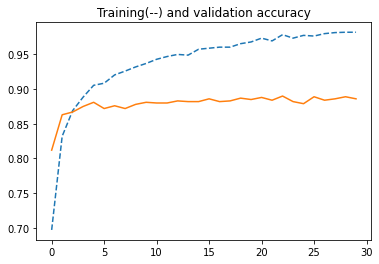

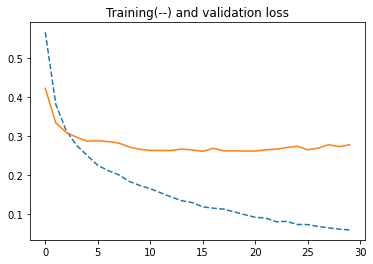

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

#### 약 90%의 검증 정확도에 도달했다. 이전에 처음부터 학습시킨 모델 ( 70% 정도)보다 좋지만 데이터 셋이 작기 때문에 과대적합이 발생한 것을 알 수 있다.
- 훈련 데이터가 부족하다
- 데이터 확장을 사용하여 개선할 수 있다.

# 2) conv 모델에 Dense망을 추가하고 학습을 수행 (2)
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다
- 엔드-투-엔드로 실행한다

In [ ]:
# 모델

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## 학습을 동결하지 않으면 모두 재 학습된다!

In [ ]:
conv_base.trainable = False
# for layer in conv_base.layers:
#    layer.trainable = False

In [ ]:
print(len(model.trainable_weights))   # 2개의 dense 층 (층마다 w 와 b 텐서)

4


### 컴파일을 수행해야 변경사항이 적용된다

In [ ]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True,
  fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                                directory=train_dir,
								target_size=(img_width,img_height),
								class_mode='binary', # 0 or 1로 labelling
								batch_size=20)

validation_generator = validation_datagen.flow_from_directory(
                                directory=validation_dir,
								target_size=(img_width,img_height),
								class_mode='binary',
								batch_size=20)




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 과대적합이 줄어든 것을 볼 수 있다.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

model.save('cats_and_dogs_1.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 18s 175ms/step - loss: 0.6560 - acc: 0.6093 - val_loss: 0.4577 - val_acc: 0.8160
Epoch 2/30
100/100 [==============================] - 17s 174ms/step - loss: 0.5074 - acc: 0.7823 - val_loss: 0.4141 - val_acc: 0.8080
Epoch 3/30
100/100 [==============================] - 17s 172ms/step - loss: 0.4397 - acc: 0.8023 - val_loss: 0.3395 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 17s 173ms/step - loss: 0.4161 - acc: 0.8065 - val_loss: 0.3234 - val_acc: 0.8660
Epoch 5/30
100/100 [==============================] - 17s 172ms/step - loss: 0.3973 - acc: 0.8139 - val_loss: 0.3035 - val_acc: 0.8760
Epoch 6/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3697 - acc: 0.8429 - val_loss: 0.2950 - val_acc: 0.8810
Epoch 7/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3800 - acc: 0.8240 - val_loss: 0.2937 - val_acc: 0.8770
Epoch 8/30
100/100 [==============================] - 1

Text(0.5, 1.0, 'Training(--) and validation loss')

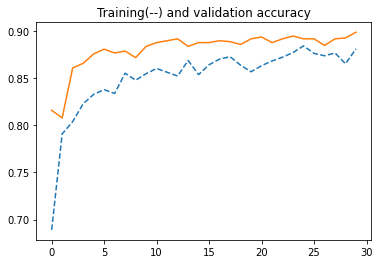

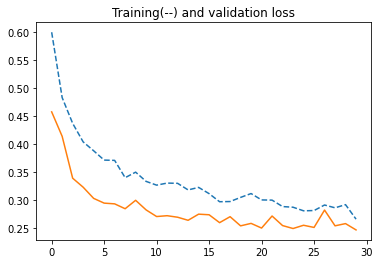

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

- 검증 정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었다.

# 미세조정
- 모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정이다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것이다.
- 상위 계층 몇개를 재학습시킨다
- 앞에서 소개한 절차, 즉, 전결합망(top)부분을 먼저 학습시킨 후에 상위계층의 미세조정을 해야 한다 (한번에 학습하면 안되고 두 단계로 나누어야 함)
 - (1)기존 네트워크 상단에 새로운 네트워크 추가한다.
 - (2) 기본 네트워크를 고정시킨다.
 - (3) 새로 추가한 부분을 훈련시킨다.
 - (4) 기본 계층 중에 학습할 상위 부분의 고정을 푼다.
 - (5) 고정을 푼 계층과 새로 추가한 계층을 함께 훈련시킨다.
- 이미 (3) 까지는 전 단계 예제에서 특성 추출할 때 이미 수행이 되어 있기 떄문에 여기서는 (4) 번쨰 단계부터 실행하기만 하면 된다.

         

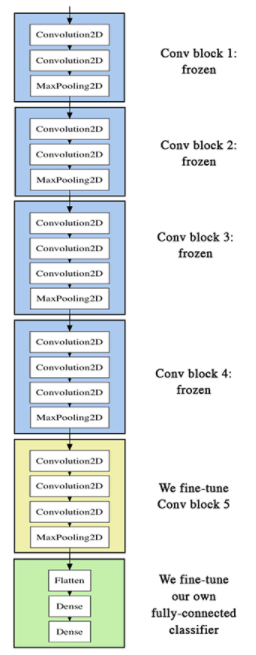

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 위에서 block 5 부분만 미세조정 하겠다

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


### 학습률을 작게 조정한다 (천천히 학습하도록)
- 미세 조정하는 층에서 학습된 표현을 조금씩 수정하기 위해

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 20s 191ms/step - loss: 0.3124 - acc: 0.8684 - val_loss: 0.2308 - val_acc: 0.9070
Epoch 2/30
100/100 [==============================] - 19s 187ms/step - loss: 0.2422 - acc: 0.8953 - val_loss: 0.2160 - val_acc: 0.9230
Epoch 3/30
100/100 [==============================] - 19s 187ms/step - loss: 0.2511 - acc: 0.8849 - val_loss: 0.2518 - val_acc: 0.9120
Epoch 4/30
100/100 [==============================] - 19s 186ms/step - loss: 0.2236 - acc: 0.9004 - val_loss: 0.2051 - val_acc: 0.9290
Epoch 5/30
100/100 [==============================] - 19s 187ms/step - loss: 0.1844 - acc: 0.9238 - val_loss: 0.2070 - val_acc: 0.9290
Epoch 6/30
100/100 [==============================] - 19s 187ms/step - loss: 0.2169 - acc: 0.9165 - val_loss: 0.2017 - val_acc: 0.9240
Epoch 7/30
100/100 [==============================] - 19s 187ms/step - loss: 0.1656 - acc: 0.9297 - val_loss: 0.2166 - val_acc: 0.9270
Epoch 8/30
100/100 [==============================] - 1

Text(0.5, 1.0, 'Training(--) and validation loss')

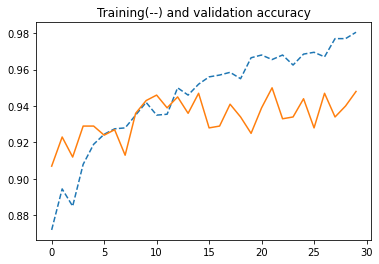

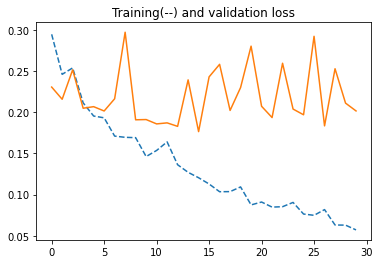

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

## 성능이 92-94%로 1% 정도 향상되었다.
- 주의 할 것은 손실함수는 향상되지 않는 것으로 나타나도, 성능이 향상될 수 있다는 것이다. (분류 성능은 어떤 임계값만 넘으면 활률적으로 개선될 수 있다)
- 정확도에 영향을 미치는 것은 손실값의 분포이지 평균이 아님.
- 지금까지 전체 캐글 경연 데이터의 10%인 2000 개만 사용해서도 높은 성능 결과 없음.

## 요약
- 과대적합을 줄이기 위해서 데이터 확장을 사용
- 전이학습 중 특성 추출방식 소개
- 전이학습 중 미세조정 방식 소개

# Exercise (연습)

## How to Visualize Filters
- https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [ ]:
# load vgg model
from keras.applications.vgg16 import VGG16
model = VGG16()
model.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# summarize filters in each convolutional layer
from tensorflow.keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()

for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


In [ ]:
model.layers[0].get_weights(), model.layers[1].get_weights()

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

In [ ]:
filters.shape

(3, 3, 3, 64)

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

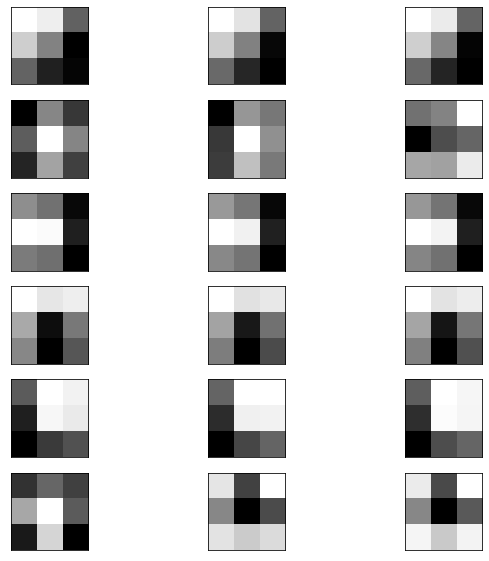

In [ ]:
# plot first few filters
plt.figure(figsize=(10,10))
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

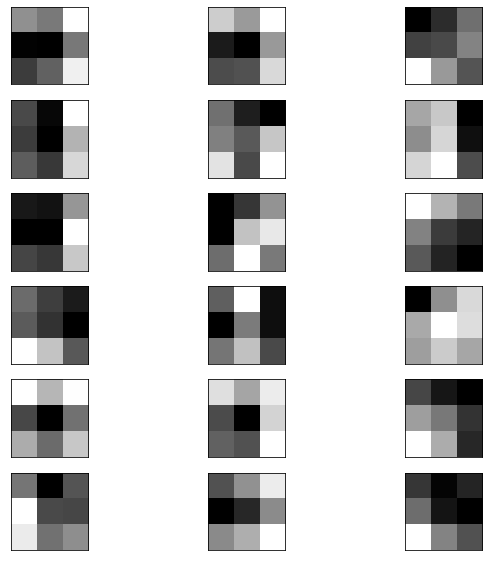

In [ ]:
# 10-th layer filters
filters, biases = model.layers[9].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
plt.figure(figsize=(10,10))
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

## How to Visualize Feature maps
- refer to lab60 for feature maps of the cats_and_dogs example code
- here we have another example

In [ ]:
# summarize feature map size for each conv layer
from tensorflow.keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [ ]:
# redefine model to output right after the first hidden layer
model = models.Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
# load the image with the required shape
from keras.preprocessing.image import load_img
img = load_img('eagle.jpg', target_size=(224, 224))

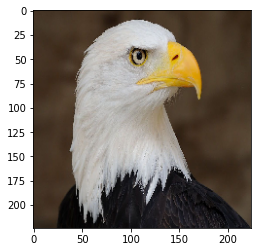

In [ ]:
plt.imshow(img)

In [ ]:
# convert the image to an array
img = image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)

In [ ]:
# prepare the image (e.g. scale pixel values for the vgg)
from keras.applications.vgg16 import preprocess_input
img = preprocess_input(img)

In [ ]:
# get feature map for first hidden layer
feature_maps = model.predict(img)

In [ ]:
feature_maps.shape

(1, 224, 224, 64)

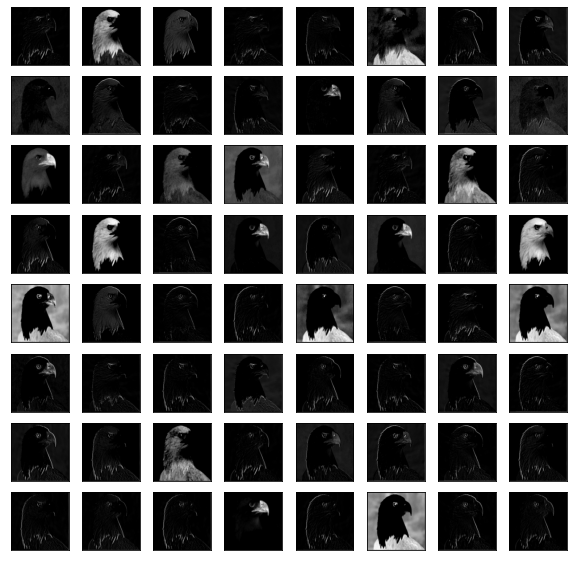

In [ ]:
# plot all 64 maps in an 8x8 squares
plt.figure(figsize=(10,10))
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


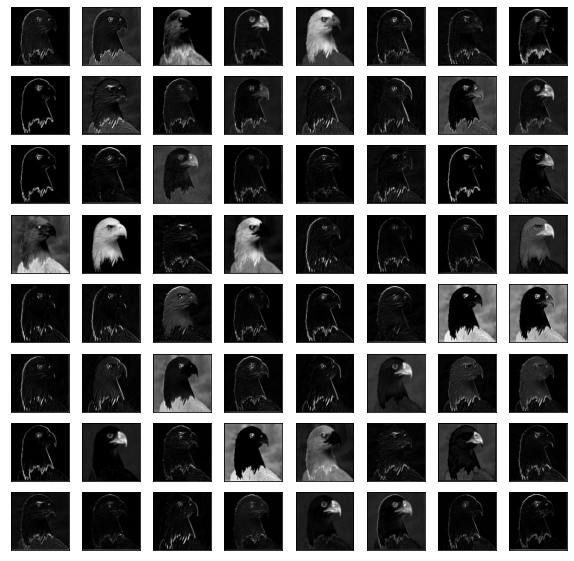

In [ ]:
# All together 
# plot feature map of third conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[3].output)
model.summary()
# load the image with the required shape
img = load_img('eagle.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(10,10))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

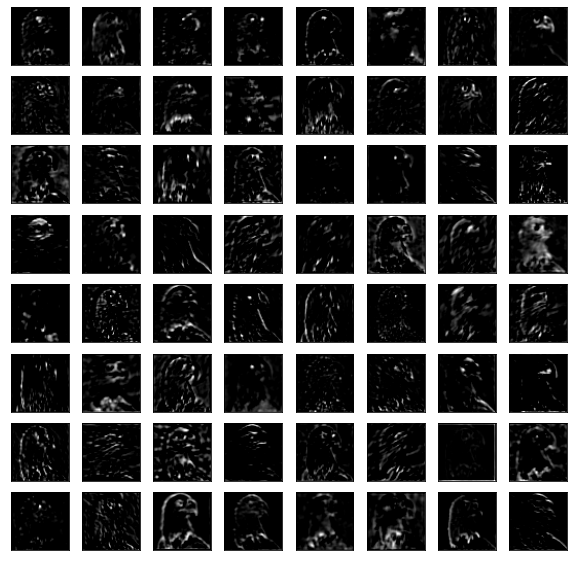

In [ ]:
# after 10-th layer
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[9].output)
model.summary()
# load the image with the required shape
img = load_img('eagle.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(10,10))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
VGG16().layers

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

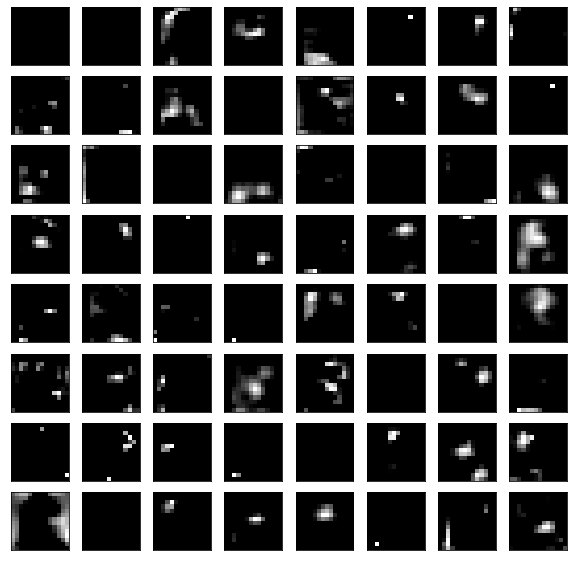

In [ ]:
# after 17-th layer
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[17].output)
model.summary()
# load the image with the required shape
img = load_img('eagle.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(10,10))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

- We can see that the result of applying the filters in the first convolutional layer is a lot of versions of the bird image with different features highlighted.
- For example, some highlight lines, other focus on the background or the foreground.

## another approach
- collect feature maps output from each block of the model in a single pass, then create an image of each.
- There are five main blocks in the image (e.g. block1, block2, etc.) that end in a pooling layer. The layer indexes of the last convolutional layer in each block are [2, 5, 9, 13, 17].
- We can define a new model that has multiple outputs, one feature map output for each of the last convolutional layer in each block.
- we can now create five separate plots for each of the five blocks in the VGG16 model for our bird photograph.

In [ ]:
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# visualize feature maps output from each block in the vgg model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('eagle.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block

In [ ]:
len(feature_maps)

5

In [ ]:
[i.shape for i in feature_maps]

[(1, 224, 224, 64),
 (1, 112, 112, 128),
 (1, 56, 56, 256),
 (1, 28, 28, 512),
 (1, 14, 14, 512)]

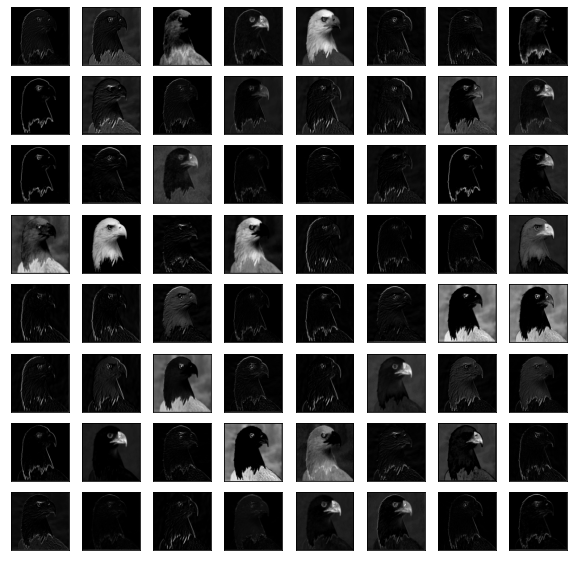

Visualization of the Feature Maps Extracted From Block 1 in the VGG16 Model






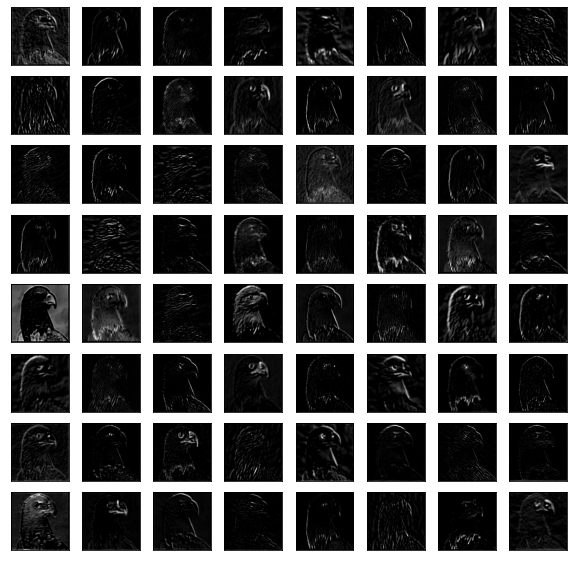

Visualization of the Feature Maps Extracted From Block 2 in the VGG16 Model






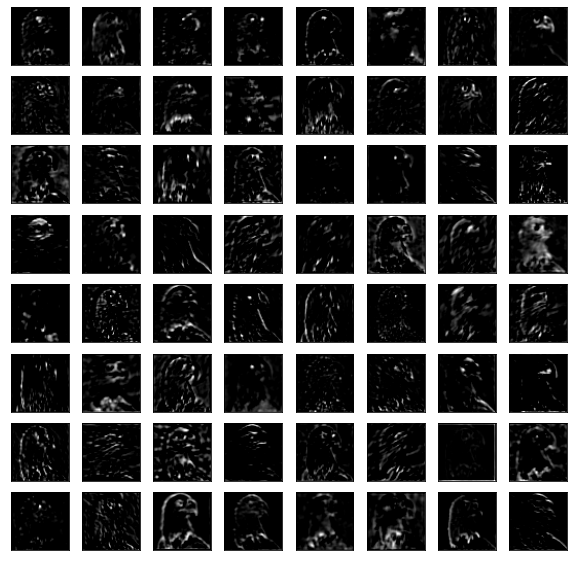

Visualization of the Feature Maps Extracted From Block 3 in the VGG16 Model






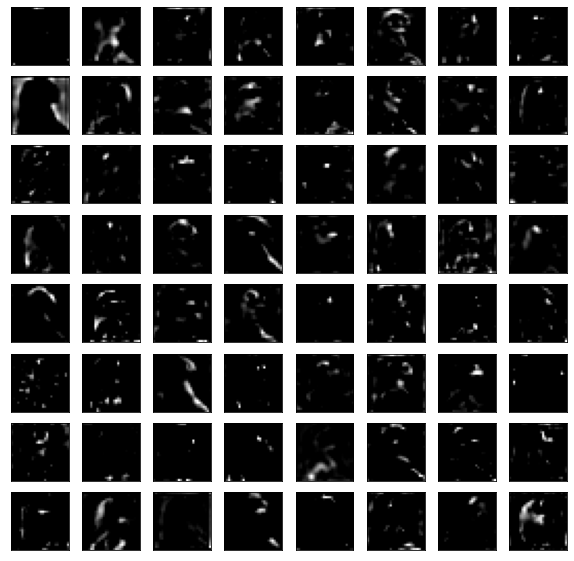

Visualization of the Feature Maps Extracted From Block 4 in the VGG16 Model






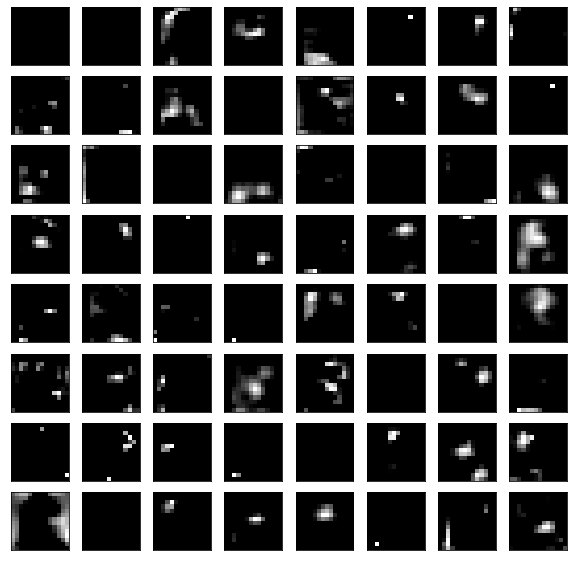

Visualization of the Feature Maps Extracted From Block 5 in the VGG16 Model






In [ ]:
square = 8
for num, fmap in enumerate(feature_maps, 1):
	# plot all 64 maps in an 8x8 squares
    ix = 1
    plt.figure(figsize=(10,10))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    
    pyplot.show()
    print("Visualization of the Feature Maps Extracted From Block {} in the VGG16 Model".format(num))
    print("\n\n\n")

- 모델 입력에 더 가까운 피처 맵이 이미지의 많은 세부 사항을 캡처하고 모델을 더 깊게 진행할수록 피처 맵이 점점 덜 세부적으로 표시됨을 알 수 있다.
- 모델이 이미지의 특징을 분류에 사용할 수 있는 보다 일반적인 개념으로 추상화하므로 이 패턴이 예상된다. 
- 모델이 독수리를 본 것이 최종 이미지에서 명확하지 않지만 일반적으로 이러한 더 깊은 특징 맵을 해석하기는 어려워진다.